What is the effect on 2- and 4-year postsecondary enrollment rates with the intervention of a VCAC college adviser? ​

- compare the program to the national average of postsecondary enrollment rates

Are there significant effects on sub-populations including these categories tracked by VDOE: Female, Male, Black, Hispanic, White, 2 or More Races, Economically Disadvantaged, Students with Disabilities? ​

- One way Anova on the VDOE data 

What is the relationship between certain college adviser activities (as measured by KPI output data) and postsecondary enrollment rates at each partner high school? ​

- principal component regression
- fixed effect lasso regression analysis

Are some activities better predictors of an increase in postsecondary enrollment? 

- feature importance

National Average Enrollment Rate vs VDOE Program Average Enrollment Rate

- t-test, p-value, and confidence interval
- 95% confidence level

- 'fafsa_submitted_rate': Proxy variable for college enrollment rate

- 'enrolled_rate': enrollment rate

- 'institutional_aid_total_dollars_rate': (per student): funding effect
- 'specific_interactions_1-on-1s_total_rate': (per student): counselor effect
- 'college_waivers_total_#_waivers_rate'
- 'act_sats_completed_rate': (per student): test taking effect
- 'college_awareness_college_fairs_at_least_one_rate': (per student): awareness effect

controls:
- 'total_male_rate'
- 'total_white_rate'
- 'total_black_rate'
- 'econ_total_rate'
- 'student_totals_seniors': Total students, perhaps the school size may have an effect on the 
- 'school_name': categorical variable capture fixed effects x 23
- 'year_starting': categorical variable to capture yearly temporal fixed effects x 6

statistical significance of total_black_rate, coefficient magnitude interpretation, and sign  
statistical significance of total_white_rate, coefficient magnitude interpretation, and sign 

statistical significance of specific_interactions_1-on-1s_total_rate, coefficient magnitude interpretation, and sign

Other Unknown 

by school is the enrollment rate different than the rest of the population?

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('cleaned_combined_2015_2020.csv')

In [32]:
# display df.columns in a dataframe
cols = df.columns
# display max rows
pd.set_option('display.max_rows', None)
# display col width to 100
pd.set_option('display.max_colwidth', 100)
cols_df = pd.DataFrame({'Variable_Names': cols})
cols_df

,Variable_Names
0,student_totals_seniors
1,specific_interactions_1-on-1s_total
2,specific_interactions_group_total
3,specific_interactions_1-on-1s_at_least_one
4,specific_interactions_group_at_least_one
5,specific_interactions_parent_meetings
6,specific_interactions_parent_meetings_at_least_one
7,total_interactions_met_with_1_plus_times_(group_and_1_1)
8,total_interactions_met_with_3_plus_times_(group_and_1_1)
9,total_interactions_met_with_5_plus_times_(group_and_1_1)


In [33]:
# Separate the variable to exclude response variable defining
y = df['enrolled_rate']

# adhoc
exploration_vars = ['institutional_aid_total_dollars_rate', 'specific_interactions_1-on-1s_total_rate', 'act_sats_completed_rate', 'college_awareness_college_fairs_at_least_one_rate']
kpi_vars = ['specific_interactions_1-on-1s_total_rate', 
            'specific_interactions_group_total_rate', 
            'specific_interactions_1-on-1s_at_least_one_rate', 
            'specific_interactions_group_at_least_one_rate', 
            'specific_interactions_parent_meetings_rate', 
            'specific_interactions_parent_meetings_at_least_one_rate', 
            'total_interactions_met_with_1_plus_times_(group_and_1_1)_rate', 
            'total_interactions_met_with_3_plus_times_(group_and_1_1)_rate', 
            'total_interactions_met_with_5_plus_times_(group_and_1_1)_rate', 
            'total_interactions_met_with_10_plus_times_(group_and_1_1)_rate']

# preprocessing
#df = df.drop(['school_name', 'year_starting'], axis=1)
df = pd.get_dummies(df, columns=['school_name', 'year_starting'])
df['gender_enrolled_ratio_f_m'] = df['enrolled_female_rate'] / df['enrolled_male_rate']
df['gender_population_ratio_f_m']= df['total_female']/df['total_male']
df['race_enrolled_ratio_w_b'] = df['enrolled_white_rate'] / df['enrolled_black_rate']
df['race_population_ratio_w_b'] = df['total_white_rate'] / df['total_black_rate']

# drop 'completeness' variables
x = df.drop(['enrolled_rate', 'enrolled_female_rate', 'enrolled_male_rate', 'enrolled_white_rate', 'enrolled_black_rate', 'total_black_rate', 'total_white_rate', 'total_female_rate', 'econ_enrolled_rate'], axis=1)
x = x[x.columns[pd.Series(x.columns).str.startswith('school_name') | pd.Series(x.columns).str.startswith('year_starting') | pd.Series(x.columns).str.endswith('rate') | pd.Series(x.columns).str.startswith('race') | pd.Series(x.columns).str.startswith('gender')]]

In [34]:
# import numpy as np
# import pandas as pd
# from scipy.stats import chi2
# from sklearn.covariance import MinCovDet

# def remove_multivariate_outliers(df, alpha):
#     # Calculate the Mahalanobis distance of each point
#     mcd = MinCovDet().fit(df)
#     dist = mcd.mahalanobis(df)
    
#     # Calculate the threshold for the Mahalanobis distance
#     threshold = chi2.ppf((1 - alpha), df=df.shape[1])
    
#     # Create a mask for the points that are not outliers
#     mask = dist <= threshold
    
#     # Return the DataFrame without outliers
#     return df[mask]

# # Usage
# df_without_outliers = remove_multivariate_outliers(df, alpha=0.005)

# y = df_without_outliers['enrolled_rate']
# x = df_without_outliers.drop(['enrolled_rate', 'enrolled_female_rate', 'enrolled_male_rate', 'enrolled_white_rate', 'enrolled_black_rate', 'total_black_rate', 'total_white_rate', 'total_female_rate', 'econ_enrolled_rate'], axis=1)
# x = x[x.columns[pd.Series(x.columns).str.startswith('school_name') | pd.Series(x.columns).str.startswith('year_starting') | pd.Series(x.columns).str.endswith('rate')]]


We prepare the data for use in a regression model by creating dummy variables for the categorical variables. We seperate the enrolled rate from the other variables to use as the response variable. Because enrolled_female_rate and enrolled_male_rate total to the complete population we include a ratio variable. We apply a similar technique for the race demographics we have available from the VDOE data, generating a ratio of one variable to the total population. We initially explored without including categorical variables for the schools and years, which resulted in no significance found via lasso regression. We then included the dummy variables for school_name and year_starting.

In [35]:
# Standardize the predictors
X_scaled = StandardScaler().fit_transform(x)

X = X_scaled

All predictors are placed on a common scale to ensure that the model is not dominated by any one variable based on the scale of the data. This ensures that the Lasso Regression selects predictors based on their relationship with the response variable, not their scale.

In [36]:
param_grid = {'alpha': np.logspace(-3, 3, 100)}

lasso_grid_search = GridSearchCV(Lasso(), param_grid, cv=5) 
lasso_grid_search.fit(X, y)
best_lasso_alpha = lasso_grid_search.best_params_['alpha']

lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(X, y)


Lasso(alpha=0.0026560877829466868)

Lasso Regression is a type of linear regression that encourage variable reduction by penalizing the size of coefficients. This L1 regularization penalty encourages the model to select only the most important predictors, and set the coefficients of the others to zero. This is useful when we have many predictors, and we want to select only the most important ones. This can help overfitting and help narrow down what predictors are most important.

In [37]:
model_results = pd.DataFrame({'var_name': x.columns,
                          'lasso_coefficient': lasso_model.coef_})
model_results.sort_values(ascending = False,by='lasso_coefficient')

,var_name,lasso_coefficient
48,school_name_Alexandria City High School,0.019506
52,school_name_Charlottesville High School,0.018863
50,school_name_Bassett High School,0.017109
61,school_name_Magna Vista High School,0.011788
53,school_name_Chatham High School (Virginia),0.011331
62,school_name_Martinsville High School,0.010350
74,year_starting_2018.0,0.007342
80,race_population_ratio_w_b,0.007302
71,year_starting_2015.0,0.007038
31,college_apps_accepted_1_plus_apps_rate,0.006979


In [38]:
from sklearn.utils import resample
from sklearn.linear_model import Lasso

# Assume X and y are your features and target variable
n_bootstrap = 1000
bootstrap_coefs = []

lasso_model = Lasso(alpha=best_lasso_alpha)

for _ in range(n_bootstrap):
    X_resample, y_resample = resample(X, y)
    lasso_model.fit(X_resample, y_resample)
    bootstrap_coefs.append(lasso_model.coef_)

bootstrap_coefs = np.array(bootstrap_coefs)

Bootstrapping coefficients in a regression model is a way to estimate the uncertainty or variability of the coefficient estimates. This is particularly useful when the assumptions of standard methods for estimating uncertainty (like standard errors) may not hold.

We know that the multi-collinearity and independence assumptions of linear regression are violated in this dataset. Bootstrapping is a way to estimate the uncertainty of the coefficient estimates without making these assumptions.

The coefficients reflect standard scaled values, so we would interpret the coefficients as the change in the response variable for a one standard deviation change in the predictor variable. To "unscale" the coefficients, we multiply hem by the standard deviation of the predictor variable.

We calculate the 95% confidence intervals for the coefficients of a Lasso regression model, and determine which coefficients are statistically significant.

In [39]:
# Calculate the 95% confidence intervals
conf_int = np.percentile(bootstrap_coefs, [2.5, 97.5], axis=0)

conf_int_df = pd.DataFrame({'var_name': x.columns,
                            'lower_bound': conf_int[0],
                            'upper_bound': conf_int[1]})
conf_int_df['coef'] = lasso_model.coef_
conf_int_df['significant'] = (conf_int_df['lower_bound'] > 0) | (conf_int_df['upper_bound'] < 0)
conf_int_df['impact']= lasso_model.coef_ * y.std()
conf_int_df['lower_impact'] = conf_int_df['lower_bound'] * y.std()
conf_int_df['upper_impact'] = conf_int_df['upper_bound'] * y.std()
display(conf_int_df[conf_int_df['significant']])

sig_conf_int_df = conf_int_df[conf_int_df['significant']]

,var_name,lower_bound,upper_bound,coef,significant,impact,lower_impact,upper_impact
48,school_name_Alexandria City High School,0.005692,0.026857,0.010038,True,0.000981,0.000556,0.002624
49,school_name_Armstrong High School,-0.044923,-0.007476,-0.036149,True,-0.003532,-0.004389,-0.000730
50,school_name_Bassett High School,0.001675,0.025845,0.014513,True,0.001418,0.000164,0.002525
52,school_name_Charlottesville High School,0.007640,0.025375,0.017425,True,0.001702,0.000746,0.002479
61,school_name_Magna Vista High School,0.000052,0.017683,0.007310,True,0.000714,0.000005,0.001728
65,school_name_Orange County High School,-0.015639,-0.000637,-0.006453,True,-0.000631,-0.001528,-0.000062
69,school_name_Washington and Lee High School,-0.029070,-0.005966,-0.028433,True,-0.002778,-0.002840,-0.000583
76,year_starting_2020.0,-0.030195,-0.008500,-0.021327,True,-0.002084,-0.002950,-0.000830
77,gender_enrolled_ratio_f_m,-0.027596,-0.001353,-0.014775,True,-0.001443,-0.002696,-0.000132


/var/folders/zx/rrsnqrlj32d4zdyzdhfp0xhh0000gn/T/ipykernel_14938/104220751.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_conf_int_df['impact_centered'] = sig_conf_int_df['impact'] - sig_conf_int_df['impact'].mean()
/var/folders/zx/rrsnqrlj32d4zdyzdhfp0xhh0000gn/T/ipykernel_14938/104220751.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sig_conf_int_df['error'] = sig_conf_int_df[['impact', 'lower_impact', 'upper_impact']].apply(lambda x: max(abs(x[0]-x[1]), abs(x[0]-x[2])), axis=1)
/var/folders/zx/rrsnqrlj32d4zdyzdhfp0xhh0000gn/T/ipykernel_14938/1

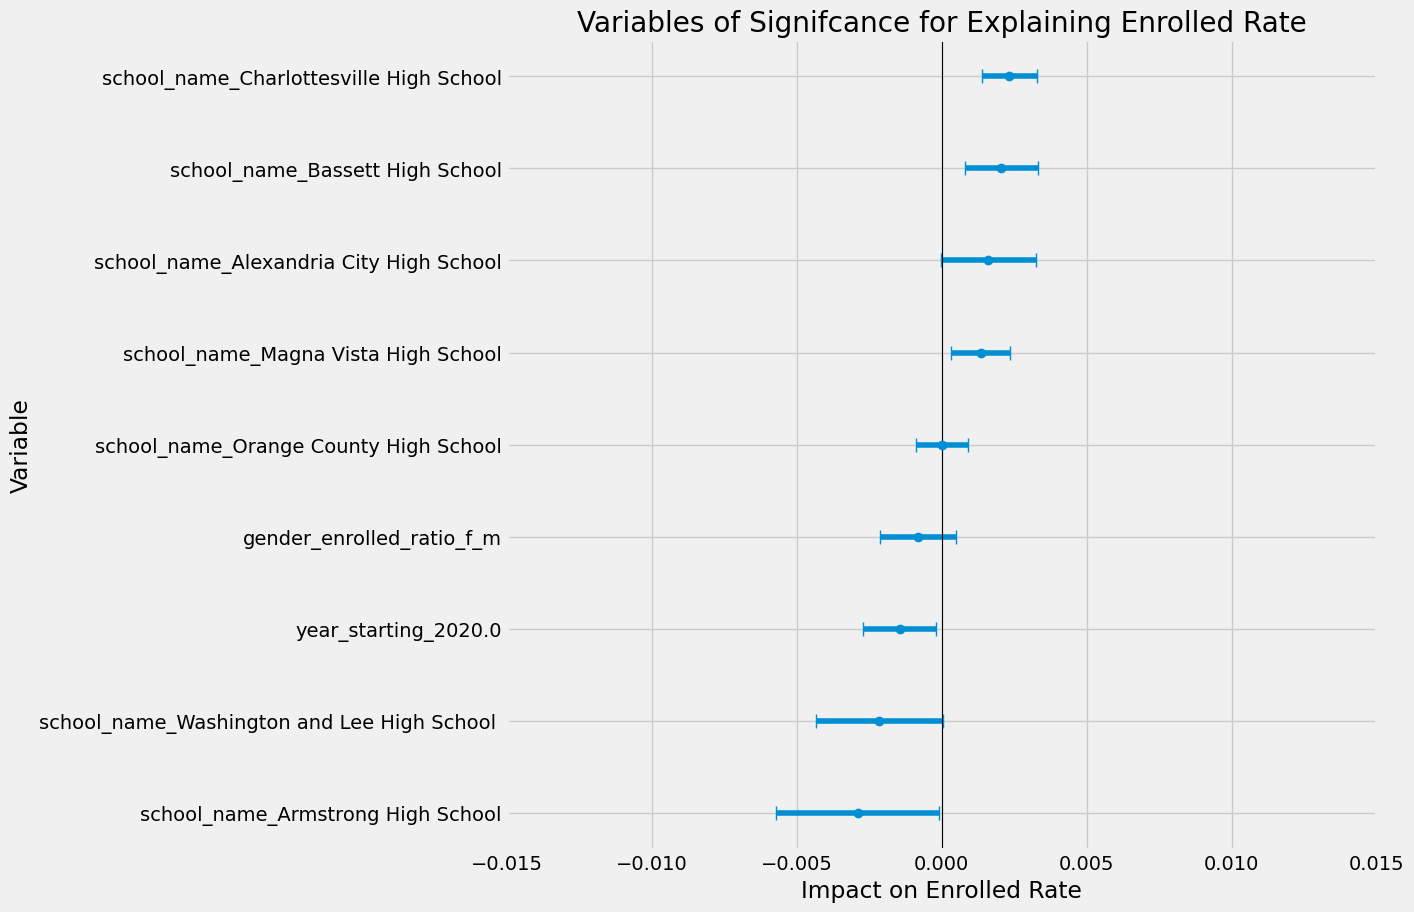

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use('fivethirtyeight')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 10))

# Center the 'impact' values at 0
sig_conf_int_df['impact_centered'] = sig_conf_int_df['impact'] - sig_conf_int_df['impact'].mean()

# Calculate the symmetric error values
sig_conf_int_df['error'] = sig_conf_int_df[['impact', 'lower_impact', 'upper_impact']].apply(lambda x: max(abs(x[0]-x[1]), abs(x[0]-x[2])), axis=1)

# filter to only significant coefficients
#conf_int_df = conf_int_df[conf_int_df['significant']]
# select only variables in the kpi 
sig_conf_int_df = sig_conf_int_df.sort_values('impact_centered')

# Plot the coefficients with error bars
ax.errorbar(sig_conf_int_df['impact_centered'], sig_conf_int_df['var_name'], xerr=sig_conf_int_df['error'], fmt='o', capsize=5)

# Set the title and labels
ax.set_title('Variables of Signifcance for Explaining Enrolled Rate')
ax.set_ylabel('Variable')
ax.set_xlabel('Impact on Enrolled Rate')

# Add a vertical line at 0
ax.axvline(0, color='black', linewidth=0.8)

# fixed scale at .15
ax.set_xlim(-0.015, 0.015)

# Show the plot
plt.show()

The resulting plot provides a visual representation of the impact of each variable on the "Enrolled Rate", along with the uncertainty of these impacts. Variables with error bars that do not cross the vertical line at 0 are considered to have a non-zero impact because the 95% confidence interval does not include 0.

After penalizing the coefficients, we find that the schools themselves have a greater impact on the enrollment rate than any other individual variable. Other features and associated impacts are not interpreted as statistically significant. 

A possibility is that there are factors that are impacting the enrollment rate that are not captured in the data. This would be described as omitted variable bias. Our conclusions and model are in effect biased by the only the data we have reviewed. In effect, this is a fixed effects lasso regression model due to the incorporation of the one-hot encoded school_name and year_starting variables.

When the school_name and year_starting dummy variables are not included the only observed significant variable is the gender_enrolled_ratio (female/male). 

In [41]:
display(sig_conf_int_df)

,var_name,lower_bound,upper_bound,coef,significant,impact,lower_impact,upper_impact,impact_centered,error
49,school_name_Armstrong High School,-0.044923,-0.007476,-0.036149,True,-0.003532,-0.004389,-0.000730,-0.002904,0.002801
69,school_name_Washington and Lee High School,-0.029070,-0.005966,-0.028433,True,-0.002778,-0.002840,-0.000583,-0.002150,0.002195
76,year_starting_2020.0,-0.030195,-0.008500,-0.021327,True,-0.002084,-0.002950,-0.000830,-0.001456,0.001253
77,gender_enrolled_ratio_f_m,-0.027596,-0.001353,-0.014775,True,-0.001443,-0.002696,-0.000132,-0.000815,0.001311
65,school_name_Orange County High School,-0.015639,-0.000637,-0.006453,True,-0.000631,-0.001528,-0.000062,-0.000002,0.000897
61,school_name_Magna Vista High School,0.000052,0.017683,0.007310,True,0.000714,0.000005,0.001728,0.001342,0.001013
48,school_name_Alexandria City High School,0.005692,0.026857,0.010038,True,0.000981,0.000556,0.002624,0.001609,0.001643
50,school_name_Bassett High School,0.001675,0.025845,0.014513,True,0.001418,0.000164,0.002525,0.002046,0.001254
52,school_name_Charlottesville High School,0.007640,0.025375,0.017425,True,0.001702,0.000746,0.002479,0.002330,0.000956


/var/folders/zx/rrsnqrlj32d4zdyzdhfp0xhh0000gn/T/ipykernel_14938/3198461046.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_int_df['error'] = conf_int_df[['impact', 'lower_impact', 'upper_impact']].apply(lambda x: max(abs(x[0]-x[1]), abs(x[0]-x[2])), axis=1)


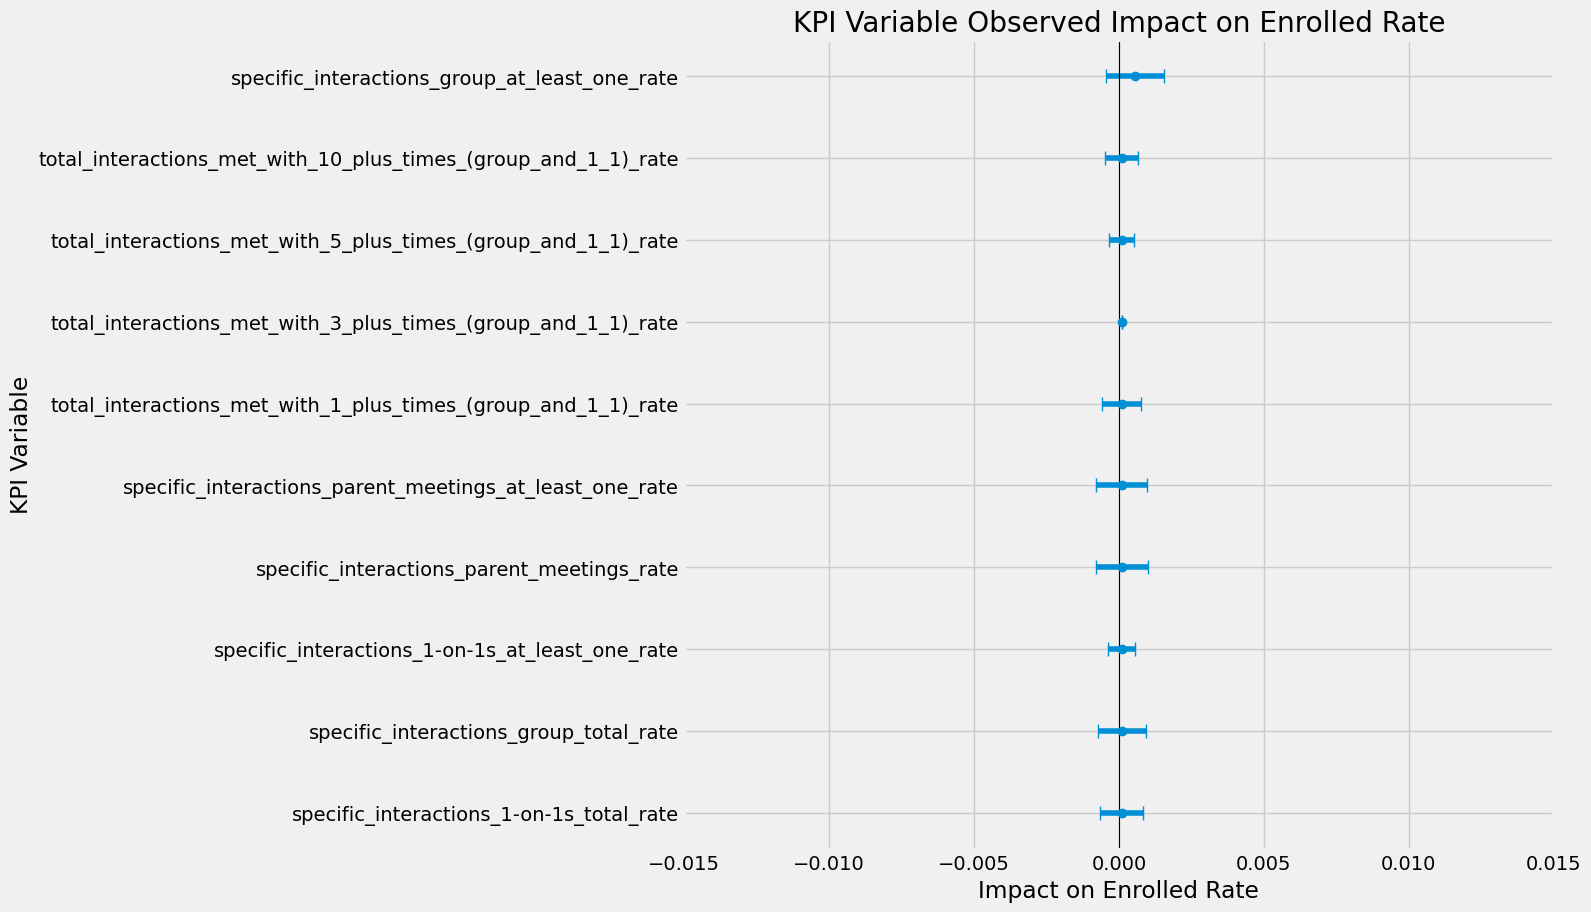

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use('fivethirtyeight')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 10))

# Center the 'impact' values at 0
conf_int_df['impact_centered'] = conf_int_df['impact'] - conf_int_df['impact'].mean()

# Calculate the symmetric error values
conf_int_df['error'] = conf_int_df[['impact', 'lower_impact', 'upper_impact']].apply(lambda x: max(abs(x[0]-x[1]), abs(x[0]-x[2])), axis=1)

# filter to only significant coefficients
#conf_int_df = conf_int_df[conf_int_df['significant']]
# select only variables in the kpi 
conf_int_df = conf_int_df[conf_int_df['var_name'].isin(kpi_vars)]
conf_int_df = conf_int_df.sort_values('impact_centered')

# Plot the coefficients with error bars
ax.errorbar(conf_int_df['impact_centered'], conf_int_df['var_name'], xerr=conf_int_df['error'], fmt='o', capsize=5)

# Set the title and labels
ax.set_title('KPI Variable Observed Impact on Enrolled Rate')
ax.set_ylabel('KPI Variable')
ax.set_xlabel('Impact on Enrolled Rate')

# Add a vertical line at 0
ax.axvline(0, color='black', linewidth=0.8)

# fixed scale at .15
ax.set_xlim(-0.015, 0.015)

# Show the plot
plt.show()

In [43]:
display(conf_int_df)

,var_name,lower_bound,upper_bound,coef,significant,impact,lower_impact,upper_impact,impact_centered,error
0,specific_interactions_1-on-1s_total_rate,-0.007547,0.000000,-0.000000,False,-0.000000,-0.000737,0.000000,0.000095,0.000737
1,specific_interactions_group_total_rate,0.000000,0.008445,0.000000,False,0.000000,0.000000,0.000825,0.000095,0.000825
2,specific_interactions_1-on-1s_at_least_one_rate,-0.004679,0.000000,-0.000000,False,-0.000000,-0.000457,0.000000,0.000095,0.000457
4,specific_interactions_parent_meetings_rate,-0.009193,0.000000,-0.000000,False,-0.000000,-0.000898,0.000000,0.000095,0.000898
5,specific_interactions_parent_meetings_at_least_one_rate,-0.009020,0.000000,-0.000000,False,-0.000000,-0.000881,0.000000,0.000095,0.000881
6,total_interactions_met_with_1_plus_times_(group_and_1_1)_rate,-0.006859,0.000000,-0.000000,False,-0.000000,-0.000670,0.000000,0.000095,0.000670
7,total_interactions_met_with_3_plus_times_(group_and_1_1)_rate,0.000000,0.000000,0.000000,False,0.000000,0.000000,0.000000,0.000095,0.000000
8,total_interactions_met_with_5_plus_times_(group_and_1_1)_rate,0.000000,0.004350,0.000000,False,0.000000,0.000000,0.000425,0.000095,0.000425
9,total_interactions_met_with_10_plus_times_(group_and_1_1)_rate,0.000000,0.005729,0.000000,False,0.000000,0.000000,0.000560,0.000095,0.000560
3,specific_interactions_group_at_least_one_rate,-0.005409,0.000837,0.004694,False,0.000459,-0.000528,0.000082,0.000554,0.000987


In the fixed effects lasso regression model, none of the kpi variables were determined to be significant. 

We see this as a partial contribution to answering the questions: 
1. What is the effect on 2- and 4-year postsecondary enrollment rates with the intervention of a VCAC college adviser? 
    
    Using the fixed effect lasso regression method, we find that the school itself has a greater impact on the enrollment rate than any other individual variable. Accordingly we cannot make a determination on the effect of a VCAC college adviser interventions on the enrollment rate. The finding that schools themselves are the most significant factor in our fixed effects lasso regression model while also finding that the interventions themselves are not significant, appears to suggest that the interventions are not having a significant impact on the enrollment rate when explored through the lens of the data we have available which is aggregated at the school level.

    To answer more thouroughly we would seek to compare individual student outcomes with and without intervention for a spread of schools in the program and outside of the program, but also share similar district, geographic, and demographic characteristics. Any such study would also be challenged with overcoming challenges associated with confounding variables under the current model data schema. An additional challenge would be controlling for school level selection bias, some schools with lower enrollment rates may be more inclined to subsquently enroll into the VCAC college adviser program, if provided the opportunity. Without controlling for these factors and examining individual level data we cannot readily make a determination on the effect of a VCAC college adviser interventions on the enrollment rate.

​2. What is the relationship between certain college adviser activities (as measured by KPI output data) postsecondary enrollment rates at each partner high school?

    Using the fixed effect lasso regression method, we find that the college adviser activities do not appear to have a statistically significant impact on the enrollment rate. The bootstrapped confidence intervals for the coefficients of the kpi variables all include 0, indicating that we cannot be confident that the kpi variables have a non-zero impact on the enrollment rate, furthermore none of the kpi variables were determined to be statistically significant, when controlling for other factors that have been made available in the data. We were unable to make a determination on the relationship between certain college adviser activities (as measured by KPI output data) and postsecondary enrollment rates at each partner high school using the data we have available.

    To answer more thouroughly on the relationship between a specific college adviser activity and enrollment rates we would require individual student level data to control for outcomes while identifying the true occurence of a counselor intention. 
